In [1]:
import pandas as pd
import numpy as np
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, \
        DistilBertTokenizerFast, DataCollatorWithPadding, pipeline, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import DatasetDict
from glob import glob
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
import re, html
import nltk
import spacy
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords



In [2]:
import torch

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # MPS = Apple Silicon GPU (M1/M2/M3…)
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print("Using device:", device)


Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

civil = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/Toxicity/civil/train-00000-of-00001.parquet")
print(civil.shape)
civil

(267516, 21)


,uid,id,comment_text,toxicity,has_active_attrs,active_attrs,male,female,LGBTQ,christian,...,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,0,668129,🤔,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,994074,"😱 but, what would they do for a bathroom?",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,5478967,😜😂🤣 We are talking about a baker who doesn't a...,0,True,[LGBTQ],0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,6,806794,😂😂😂😂 is this really the big gossip of barrow ?...,0,True,[white],0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,8,5133351,😂😂 you are excited for 2020 for what?? To be l...,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267511,445282,718068,"""\nThe Ontario government says it will maintai...",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267512,445283,400024,"""\nIn a statement, Clinton thanked Wasserman S...",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267513,445288,5015700,"!This rigid and misleading ""take"" on clerical ...",0,True,[christian],0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
267514,445291,534321,!/3 of this Alaska's voters are like me not re...,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
civil['toxicity'].value_counts()

,count
toxicity,
0,237173
1,30343


In [6]:
civil[civil['toxicity']==1]

,uid,id,comment_text,toxicity,has_active_attrs,active_attrs,male,female,LGBTQ,christian,...,other_religions,black,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
27,41,6324072,…what about the liberal media trolls like AP w...,1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
31,48,5655525,…or the market is manipulated and you lose all...,1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,51,5625871,…it's 'traitorous buffoon'.,1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48,77,5663622,"•\n\nI don't mean to insult her, but Hillary l...",1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56,89,6076952,“…and if black guys weren't so heavily involve...,1,True,"[male, christian, muslim, black, white]",1,0,0,1,...,0,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267464,445211,5521056,""" ... Love the hypocrisy.""\n\nI guess you miss...",1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
267473,445230,5511716,""" .. You're waiting on the goodwill and the mo...",1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
267477,445234,6091731,""" .. Really, does the Trudeau government think...",1,False,[],0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
267480,445241,5320764,""" .. we must fight for our future on our own ...",1,True,[male],1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


…or the market is manipulated and you lose all, or all but a pittance.

Wall Street is corrupt and rigged now.  

What few regulations we have left are wholly insufficient to safeguard small investors now.


And further deregulation will make Wall Street and the banksters even more corrupt and crooked.

In [7]:
civil['toxicity'].value_counts()

,count
toxicity,
0,237173
1,30343


#### Start Medical

#### End Medical

<Axes: xlabel='toxicity', ylabel='count'>

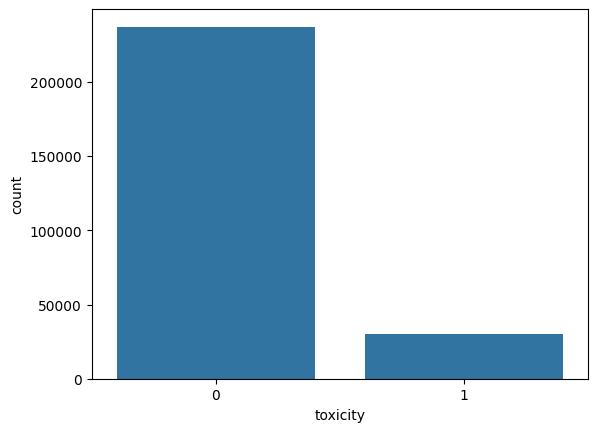

In [8]:
sns.barplot(civil['toxicity'].value_counts())

In [9]:
# map labels -> ids (adjust if your labels differ)
#label2id = {"digestive system": 0, "cardiovascular": 1, "neoplasms": 2, "nervous system": 3, "general pathological": 4}
label2id = {"non-toxic": 0, "toxic": 1}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'non-toxic', 1: 'toxic'}

In [10]:
unique_labels = civil['toxicity'].unique().tolist()
print(f'# of unique labels: {unique_labels}')
label2id = {"non-toxic": 0, "toxic": 1}
civil['labels'] = civil['toxicity']
civil['civil'] = civil['labels'].apply(lambda x: id2label[x])
civil

# of unique labels: [0, 1]


,uid,id,comment_text,toxicity,has_active_attrs,active_attrs,male,female,LGBTQ,christian,...,white,identity_any,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,labels,civil
0,0,668129,🤔,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic
1,2,994074,"😱 but, what would they do for a bathroom?",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic
2,4,5478967,😜😂🤣 We are talking about a baker who doesn't a...,0,True,[LGBTQ],0,0,1,0,...,0,1,0,0,0,0,0,0,0,non-toxic
3,6,806794,😂😂😂😂 is this really the big gossip of barrow ?...,0,True,[white],0,0,0,0,...,1,1,0,0,0,0,0,0,0,non-toxic
4,8,5133351,😂😂 you are excited for 2020 for what?? To be l...,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267511,445282,718068,"""\nThe Ontario government says it will maintai...",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic
267512,445283,400024,"""\nIn a statement, Clinton thanked Wasserman S...",0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic
267513,445288,5015700,"!This rigid and misleading ""take"" on clerical ...",0,True,[christian],0,0,0,1,...,0,1,0,0,0,0,0,0,0,non-toxic
267514,445291,534321,!/3 of this Alaska's voters are like me not re...,0,False,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,non-toxic


In [11]:
df_train = civil[['comment_text','toxicity']]
df_train

,comment_text,toxicity
0,🤔,0
1,"😱 but, what would they do for a bathroom?",0
2,😜😂🤣 We are talking about a baker who doesn't a...,0
3,😂😂😂😂 is this really the big gossip of barrow ?...,0
4,😂😂 you are excited for 2020 for what?? To be l...,0
...,...,...
267511,"""\nThe Ontario government says it will maintai...",0
267512,"""\nIn a statement, Clinton thanked Wasserman S...",0
267513,"!This rigid and misleading ""take"" on clerical ...",0
267514,!/3 of this Alaska's voters are like me not re...,0


In [12]:
df_train.columns

Index(['comment_text', 'toxicity'], dtype='object')

In [13]:

from datasets import ClassLabel

# convert the dataset using Datasets library for faster processing
civil_df = Dataset.from_pandas(df_train)

# Convert 'labels' column to ClassLabel type
class_label = ClassLabel(names=['non-toxic', 'toxic'])
civil_df = civil_df.cast_column('toxicity', class_label)

civil_df = civil_df.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column='toxicity'
)

train_valid = civil_df["train"].train_test_split(
    test_size=0.125,
    seed=42,
    stratify_by_column='toxicity'
)

civil = DatasetDict({
    "train": train_valid["train"],
    "validation": train_valid["test"],   # this is your val set
    "test": civil_df["test"],
})

civil

Casting the dataset:   0%|          | 0/267516 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'toxicity'],
        num_rows: 187260
    })
    validation: Dataset({
        features: ['comment_text', 'toxicity'],
        num_rows: 26752
    })
    test: Dataset({
        features: ['comment_text', 'toxicity'],
        num_rows: 53504
    })
})

In [14]:
from collections import Counter

for split in ("train","validation","test"):
    if split in civil:
        print(split, Counter(civil[split]["toxicity"]))

train Counter({0: 166020, 1: 21240})
validation Counter({0: 23718, 1: 3034})
test Counter({0: 47435, 1: 6069})


In [15]:
train_texts = set(civil["train"]["comment_text"])
val_texts   = set(civil["validation"]["comment_text"])
print("Overlap:", len(train_texts & val_texts))


Overlap: 0


In [16]:
REG_EX = re.compile(r'<[^>]+>')
def preprocess_and_tokenize(batch, tokenizer):
    texts = []
    for t in batch['comment_text']:
        if not isinstance(t, str):
            t = "" if t is None else str(t)
        t = REG_EX.sub("", t)
        t = html.unescape(t)
        t = " ".join(t.split())
        texts.append(t)

    out = tokenizer(texts, truncation=True, max_length=512)
    out["toxicity"] = batch["toxicity"]    # keep labels

    return out

In [17]:
model_ckpt = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
remove_cols = ["comment_text"]  # drop raw text after tokenization
civil_enc = civil.map(
    preprocess_and_tokenize,
    batched=True,
    batch_size=None,
    remove_columns=remove_cols,
    fn_kwargs={'tokenizer': tokenizer}
)

Map:   0%|          | 0/187260 [00:00<?, ? examples/s]

Map:   0%|          | 0/26752 [00:00<?, ? examples/s]

Map:   0%|          | 0/53504 [00:00<?, ? examples/s]

In [19]:
# DataCollator with padding creates a batch of data and also pads text to make all sequences to be of same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Model Training

In [20]:
label2id

{'non-toxic': 0, 'toxic': 1}

In [21]:
# initialize the classification model with pre-trained classifier and number of unique lables - Positive and Negative
num_labels = len(label2id)
seq_clf_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
).to(device)


seq_clf_model.config.id2label

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 'non-toxic', 1: 'toxic'}

In [22]:
use_mps = hasattr(__import__("torch").backends, "mps") and __import__("torch").backends.mps.is_available()


In [23]:
def compute_metrics(eval_pred):
    """
    eval_pred: (predictions, labels) from Trainer.
      - predictions: logits or a tuple where logits are first element
      - labels: ground-truth label ids
    Returns a dict of scalar metrics (Trainer will log/save these).
    """
    logits, labels = eval_pred
    # Some models return (logits, ...) — grab logits
    if isinstance(logits, (tuple, list)):
        logits = logits[0]

    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)

    # Weighted = accounts for class imbalance; good default for sentiment
    prec, rec, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    # Optional: macro F1 (treats all classes equally, regardless of support)
    f1_macro = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_w,          # <-- matches your TrainingArguments(metric_for_best_model="f1")
        "f1_macro": f1_macro # <-- extra visibility if you want it
    }

In [24]:
device

device(type='cuda')

In [25]:
if use_mps:
    torch.mps.empty_cache()            # clears cached memory on MPS (useful between runs)
    # Use float32 or bfloat16 on newer stacks. Avoid fp16 amp flags on MPS.
    prefer_bf16 = torch.cuda.is_bf16_supported() if hasattr(torch, "cuda") else False  # always False on Macs; just sanity
    torch_dtype = torch.float32
else:
    torch_dtype = torch.float32

In [26]:
batch_size = 64
per_device = 8   # safer per-device batch size for MPS; adjust if you have headroom
grad_accum = max(1, batch_size // per_device)

logging_steps = len(civil["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-civil"
use_mps = hasattr(__import__("torch").backends, "mps") and __import__("torch").backends.mps.is_available()

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=per_device,
                                  per_device_eval_batch_size=per_device,
                                  gradient_accumulation_steps=grad_accum,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  greater_is_better=True,
                                  save_total_limit=2,
                                  logging_steps=50,
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  fp16=False,                        # don't force AMP fp16 on MPS
                                  bf16=False,
                                  log_level="error")

In [27]:
# Rename "toxicity" column to "labels" for Trainer compatibility
civil_enc_train = civil_enc["train"].rename_column("toxicity", "labels")
civil_enc_val = civil_enc["validation"].rename_column("toxicity", "labels")

trainer = Trainer(model=seq_clf_model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=civil_enc_train,
                  eval_dataset=civil_enc_val,
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-195442067.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=seq_clf_model, args=training_args,
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: karthik-vishwanath (karthik-vishwanath-tcs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,F1 Macro
1,0.190900,0.174506,0.926622,0.922384,0.926622,0.923896,0.804151
2,0.144700,0.179261,0.928155,0.923912,0.928155,0.925367,0.807664


In [28]:
preds_output = trainer.predict(civil_enc["test"])
preds_output.metrics

{'test_runtime': 278.204,
 'test_samples_per_second': 192.319,
 'test_steps_per_second': 24.04}

In [29]:
# evaluate the model with validation dataset
trainer.evaluate()


{'eval_loss': 0.1792614459991455,
 'eval_accuracy': 0.92815490430622,
 'eval_precision': 0.9239123106123383,
 'eval_recall': 0.92815490430622,
 'eval_f1': 0.9253665598500767,
 'eval_f1_macro': 0.8076642808074783,
 'eval_runtime': 138.7136,
 'eval_samples_per_second': 192.858,
 'eval_steps_per_second': 24.107,
 'epoch': 2.0}